<a href="https://colab.research.google.com/github/saritmaitra/ARIMA-Model-for-prediction/blob/master/Lime%26Shap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyforest
from pyforest import *
import datetime, pickle, copy
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
import matplotlib.pyplot as plt
%matplotlib inline  
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

  Created wheel for pyforest: filename=pyforest-1.0.3-py2.py3-none-any.whl size=13715 sha256=eef030cc7a3f906bfbd89424bbf67b719db305d2eef923df8bf8d58944e224dd
  Stored in directory: /root/.cache/pip/wheels/af/0b/39/340a7f15fc8d4ff5ab50847b28789afea04452a9d51b9721b5
Successfully built pyforest


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
'''Data Prep'''
from sklearn import preprocessing as pp
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

'''Algos'''
from sklearn import model_selection
import lightgbm as lgb 
from lightgbm import LGBMClassifier
from time import time
from lightgbm import *

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving insurance_claims.csv to insurance_claims.csv


In [ ]:
# Import data 
df = pd.read_csv("insurance_claims.csv")
df.head()

<IPython.core.display.Javascript object>

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,MALE,MD,craft-repair,sleeping,husband,53300,0,2015-01-25,Single Vehicle Collision,Side Collision,Major Damage,Police,SC,Columbus,9935 4th Drive,5,1,YES,1,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,MALE,MD,machine-op-inspct,reading,other-relative,0,0,2015-01-21,Vehicle Theft,?,Minor Damage,Police,VA,Riverwood,6608 MLK Hwy,8,1,?,0,0,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,FEMALE,PhD,sales,board-games,own-child,35100,0,2015-02-22,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NY,Columbus,7121 Francis Lane,7,3,NO,2,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,FEMALE,PhD,armed-forces,board-games,unmarried,48900,-62400,2015-01-10,Single Vehicle Collision,Front Collision,Major Damage,Police,OH,Arlington,6956 Maple Drive,5,1,?,1,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,MALE,Associate,sales,board-games,unmarried,66000,-46000,2015-02-17,Vehicle Theft,?,Minor Damage,None,NY,Arlington,3041 3rd Ave,20,1,NO,0,1,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN


<IPython.core.display.Javascript object>

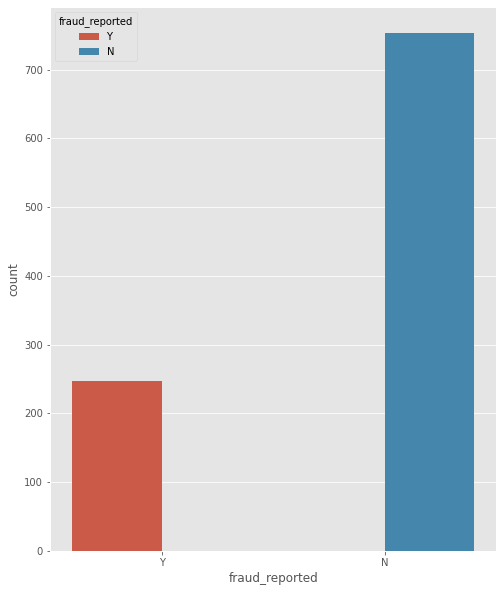

In [ ]:
ax = sns.countplot(x='fraud_reported', data=df, hue='fraud_reported')

In [ ]:
df['fraud_reported'].value_counts() # Count number of frauds vs non-frauds

N    753
Y    247
Name: fraud_reported, dtype: int64

In [ ]:
data = df.copy()
data['fraud_reported'].replace(to_replace='Y', value=1, inplace=True)
data['fraud_reported'].replace(to_replace='N',  value=0, inplace=True)
data['csl_per_person'] = data.policy_csl.str.split('/', expand=True)[0]
data['csl_per_accident'] = data.policy_csl.str.split('/', expand=True)[1]
data['vehicle_age'] = 2020 - data['auto_year'] # Deriving the age of the vehicle based on the year value 
bins = [-1, 3, 6, 9, 12, 17, 20, 24]  # Factorize according to the time period of the day.
names = ["past_midnight", "early_morning", "morning", 'fore-noon', 'afternoon', 'evening', 'night']
data['incident_period_of_day'] = pd.cut(data.incident_hour_of_the_day, bins, labels=names).astype(object)
# dropping unimportant columns

data = data.drop(columns = [
    'policy_number', 
    'policy_csl',
    'insured_zip',
    'policy_bind_date', 
    'incident_date', 
    'incident_location', 
    '_c39', 
    'auto_year', 
    'incident_hour_of_the_day'], axis=1)

data.head(2)

<IPython.core.display.Javascript object>

,months_as_customer,age,policy_state,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,fraud_reported,csl_per_person,csl_per_accident,vehicle_age,incident_period_of_day
0,328,48,OH,1000,1406.91,0,MALE,MD,craft-repair,sleeping,husband,53300,0,Single Vehicle Collision,Side Collision,Major Damage,Police,SC,Columbus,1,YES,1,2,YES,71610,6510,13020,52080,Saab,92x,1,250,500,16,early_morning
1,228,42,IN,2000,1197.22,5000000,MALE,MD,machine-op-inspct,reading,other-relative,0,0,Vehicle Theft,?,Minor Damage,Police,VA,Riverwood,1,?,0,0,?,5070,780,780,3510,Mercedes,E400,1,250,500,13,morning


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_state                 1000 non-null   object 
 3   policy_deductable            1000 non-null   int64  
 4   policy_annual_premium        1000 non-null   float64
 5   umbrella_limit               1000 non-null   int64  
 6   insured_sex                  1000 non-null   object 
 7   insured_education_level      1000 non-null   object 
 8   insured_occupation           1000 non-null   object 
 9   insured_hobbies              1000 non-null   object 
 10  insured_relationship         1000 non-null   object 
 11  capital-gains                1000 non-null   int64  
 12  capital-loss                 1000 non-null   int64  
 13  incident_type      

In [ ]:
# turning object columns type to categorical for easing the transformation process
categorical = data.select_dtypes(include= ['object']).columns
for col in categorical:
   data[col] = data[col].astype('category')
# categorical values ==> numeric values
data[categorical] = data[categorical].apply(lambda x: x.cat.codes)
data.head()

,months_as_customer,age,policy_state,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,fraud_reported,csl_per_person,csl_per_accident,vehicle_age,incident_period_of_day
0,328,48,2,1000,1406.91,0,1,4,2,17,0,53300,0,2,3,0,4,4,1,1,2,1,2,2,71610,6510,13020,52080,10,1,1,1,2,16,1
1,228,42,1,2000,1197.22,5000000,1,4,6,15,2,0,0,3,0,1,4,5,5,1,0,0,0,0,5070,780,780,3510,8,12,1,1,2,13,4
2,134,29,2,2000,1413.14,5000000,0,6,11,2,3,35100,0,0,2,1,4,1,1,3,1,2,3,1,34650,7700,3850,23100,4,30,0,0,1,13,4
3,256,41,0,2000,1415.74,6000000,0,6,1,2,4,48900,-62400,2,1,0,4,2,0,1,0,1,2,1,63400,6340,6340,50720,3,34,1,1,2,6,1
4,228,44,0,1000,1583.91,6000000,1,0,11,2,4,66000,-46000,3,0,1,2,1,0,1,1,0,1,1,6500,1300,650,4550,0,31,0,2,0,11,2


In [ ]:
data._get_numeric_data().columns

Index(['months_as_customer', 'age', 'policy_state', 'policy_deductable', 'policy_annual_premium', 'umbrella_limit', 'insured_sex',
       'insured_education_level', 'insured_occupation', 'insured_hobbies', 'insured_relationship', 'capital-gains', 'capital-loss', 'incident_type',
       'collision_type', 'incident_severity', 'authorities_contacted', 'incident_state', 'incident_city', 'number_of_vehicles_involved',
       'property_damage', 'bodily_injuries', 'witnesses', 'police_report_available', 'total_claim_amount', 'injury_claim', 'property_claim',
       'vehicle_claim', 'auto_make', 'auto_model', 'fraud_reported', 'csl_per_person', 'csl_per_accident', 'vehicle_age', 'incident_period_of_day'],
      dtype='object')

<IPython.core.display.Javascript object>

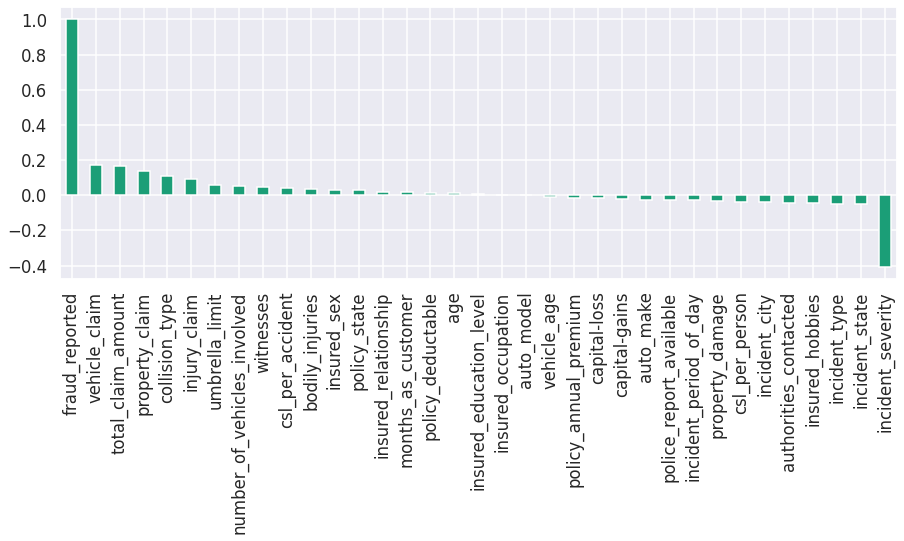

In [ ]:
# Checking Correlation of "fraud_reported" with other variables on a different plot
sns.set(style='darkgrid', context='talk', palette='Dark2')
plt.figure(figsize=(15,5))
data.corr()['fraud_reported'].sort_values(ascending = False).plot(kind='bar')

In [ ]:
X = data.drop(columns = ['fraud_reported'], axis=1)  # predictor variables
y = data['fraud_reported']  # target variable
#y = pd.DataFrame(data['fraud_reported'])  # target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=7)
print('length of X_train and X_test: ', len(X_train), len(X_test))
print('length of y_train and y_test: ', len(y_train), len(y_test))

length of X_train and X_test:  800 200
length of y_train and y_test:  800 200


In [ ]:
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

In [ ]:
print("Training XGB Classifier...")
tic = time()
model = XGBClassifier(early_stopping=True)

model.fit(X_train, y_train.values)
print("done in {:.3f}s".format(time() - tic))
print('Model trained')
AccuracyScore = cross_val_score(model, X_train, y_train, cv=10)
print('Accuracy score:', format(round(AccuracyScore.mean(),2)))
BalancedScore = cross_val_score(model, X_train, y_train, cv=10,scoring="balanced_accuracy")
print('Accuracy balance:', format(round(BalancedScore.mean(),2)))
print("done in {:.3f}s".format(time() - tic))

Training XGB Classifier...
done in 0.131s
Model trained
Accuracy score: 0.82
Accuracy balance: 0.77
done in 2.376s


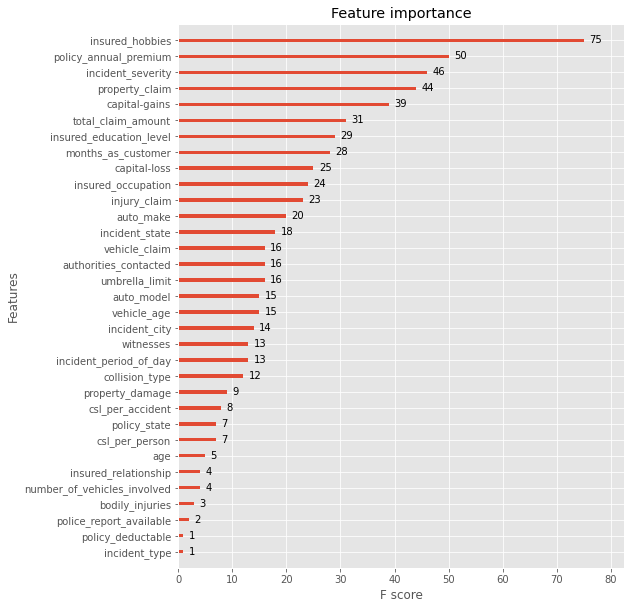

In [ ]:
from xgboost import plot_importance
plt.style.use('ggplot')
# Feature importance
plt.rcParams['figure.figsize'] = [8,10]
plot_importance(model)

In [ ]:
# I"m creating one big dataframe that includes both train and test
# to plot them on same plot using seaborn's boxplot
train_expl_df.rename(columns={'weight': 'contribution'}, inplace=True)
test_expl_df.rename(columns={'weight': 'contribution'}, inplace=True)
train_expl_df['data'] = 'train'
test_expl_df['data'] = 'test'
train_test_expl_df = pd.concat([train_expl_df, test_expl_df])
sns.boxplot(x='feature', y='contribution', hue='data', order=features,
            data=train_test_expl_df.loc[train_test_expl_df.feature!=''],
            palette={'train': 'salmon', 
                     'test':'deepskyblue'})
plt.legend(loc=9)
plt.title('Distributions of Feature Contributions');

In [ ]:
!pip install eli5
from eli5.sklearn import PermutationImportance

     |████████████████████████████████| 112kB 4.3MB/s 


Using TensorFlow backend.


In [ ]:
import eli5
# let's check the importance of each attributes
perm = PermutationImportance(model, random_state = 0).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.1360 ± 0.0527,incident_severity
0.0970 ± 0.0242,insured_hobbies
0.0060 ± 0.0160,insured_education_level
0.0030 ± 0.0136,policy_annual_premium
0.0030 ± 0.0049,witnesses
0.0030 ± 0.0049,umbrella_limit
0.0020 ± 0.0102,incident_state
0.0020 ± 0.0049,police_report_available
0 ± 0.0000,csl_per_accident
0 ± 0.0000,policy_state


In [ ]:
perm_train = PermutationImportance(model, scoring='accuracy',
                                   n_iter=100, random_state=1)
# fit and see the permuation importances
perm_train.fit(X_train, y_train)
eli5.explain_weights_df(perm_train, feature_names=X_train.columns.tolist()).head()


,feature,weight,std
0,incident_severity,0.222725,0.011438
1,insured_hobbies,0.102337,0.006814
2,authorities_contacted,0.019700,0.003562
3,policy_annual_premium,0.018512,0.003757
4,property_claim,0.015238,0.003521


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

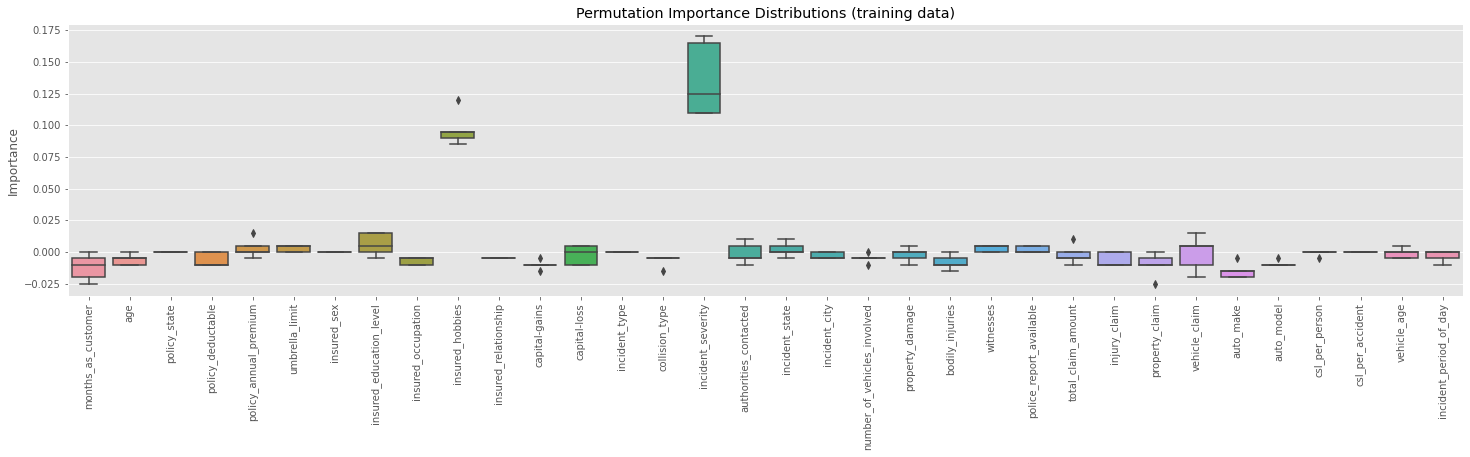

In [ ]:
# figure size in inches
from matplotlib import rcParams
rcParams['figure.figsize'] = 25,5

perm_train_df = pd.DataFrame(data=perm.results_,
                                      columns=X.columns)
(sns.boxplot(data=perm_train_df)
        .set(title='Permutation Importance Distributions (training data)',
             ylabel='Importance'));
plt.xticks(rotation=90)
plt.show()

In [ ]:
!pip install pdpbox
from pdpbox import pdp, get_dataset, info_plots

     |████████████████████████████████| 57.7MB 66kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690722 sha256=259e6467d8950ce6b7eb87006b36b3b8abfc20d8b5bbf752dfa8091327fd901b
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


In [ ]:
data.head(1)

,months_as_customer,age,policy_state,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,fraud_reported,csl_per_person,csl_per_accident,vehicle_age,incident_period_of_day
0,328,48,2,1000,1406.91,0,1,4,2,17,0,53300,0,2,3,0,4,4,1,1,2,1,2,2,71610,6510,13020,52080,10,1,1,1,2,16,1


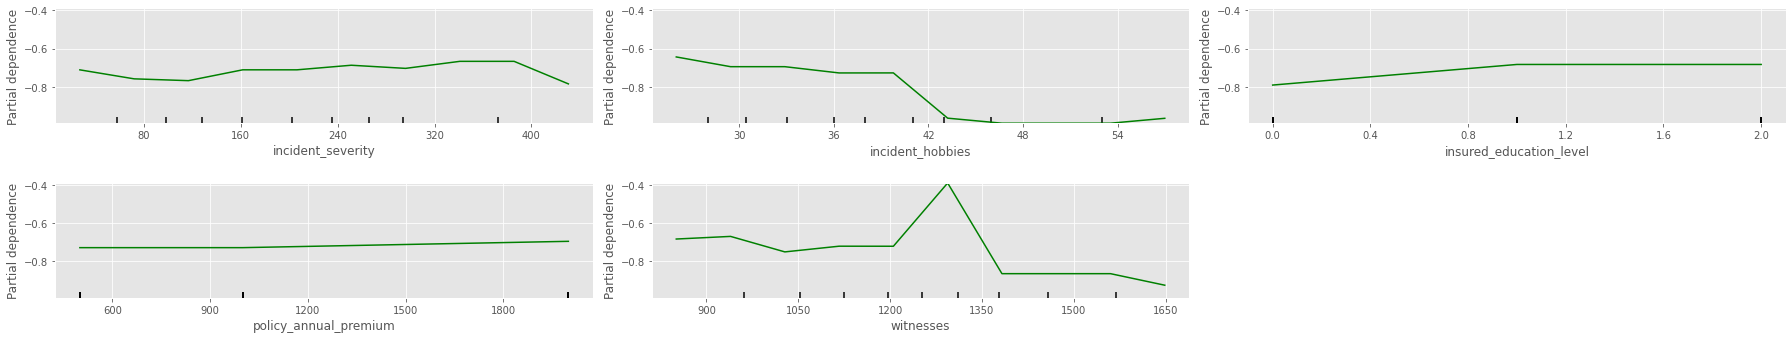

In [ ]:
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier()
clf.fit(X=X_train, y=y_train)

# Here we make the plot
plots = plot_partial_dependence(clf ,       
                                   features=[0,1, 2,3,4], # column numbers of plots we want to show
                                   X=X_train,            # raw predictors data.
                                   feature_names=['incident_severity','incident_hobbies', 
                                                  'insured_education_level','policy_annual_premium','witnesses'], # labels on graphs
                                   grid_resolution=10) # number of values to plot on x axis
plt.tight_layout()
plt.show()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


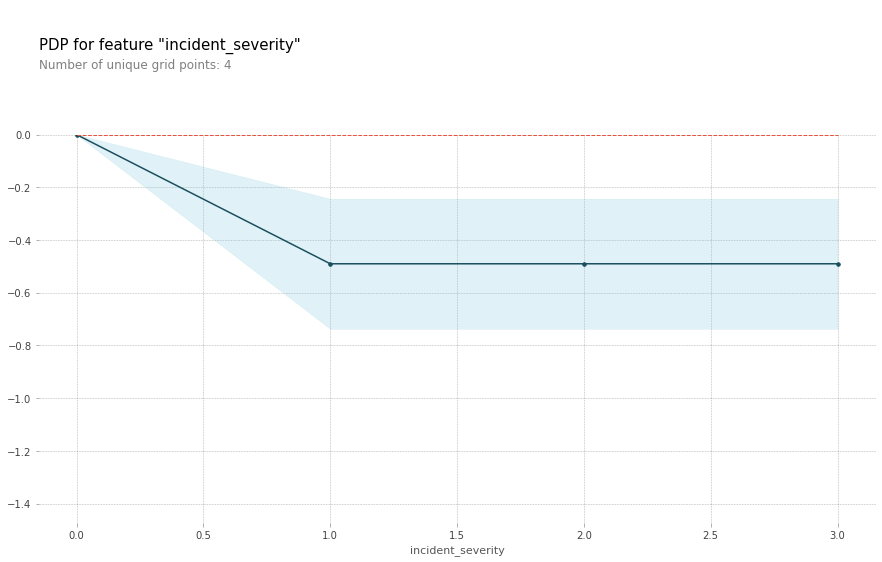

In [ ]:
base_features = X_train.columns.values.tolist()
feature_name = 'incident_severity'
pdp = pdp.pdp_isolate(model=model, dataset=X_test, 
                      model_features = base_features, 
                      feature = feature_name)
pdp.pdp_plot(pdp, feature_name)
plt.show()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


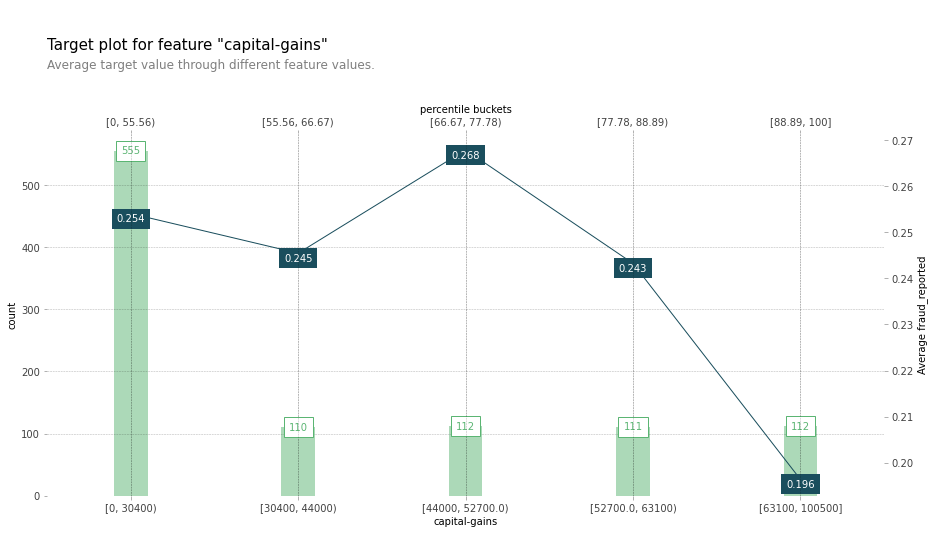

In [ ]:
fig, axes, summary_df = info_plots.target_plot(\
                                               df=data, feature='capital-gains', 
                                               feature_name='capital-gains', target='fraud_reported', 
                                               show_percentile=True)

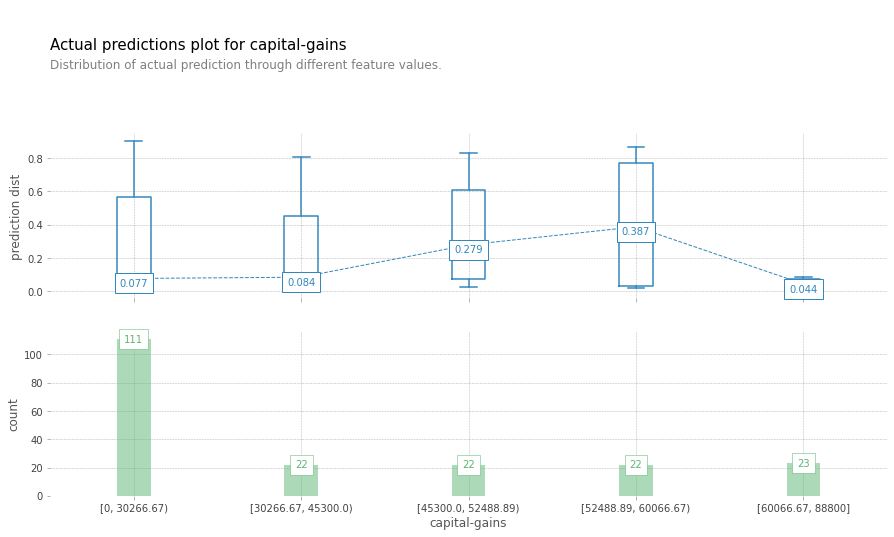

In [ ]:
fig, axes, summary_df = info_plots.actual_plot(\
                                               model, X_test, feature='capital-gains', 
                                               feature_name='capital-gains',predict_kwds={})

In [111]:
df.auto_model.unique()

array(['92x', 'E400', 'RAM', 'Tahoe', 'RSX', '95', 'Pathfinder', 'A5',
       'Camry', 'F150', 'A3', 'Highlander', 'Neon', 'MDX', 'Maxima',
       'Legacy', 'TL', 'Impreza', 'Forrestor', 'Escape', 'Corolla',
       '3 Series', 'C300', 'Wrangler', 'M5', 'X5', 'Civic', 'Passat',
       'Silverado', 'CRV', '93', 'Accord', 'X6', 'Malibu', 'Fusion',
       'Jetta', 'ML350', 'Ultima', 'Grand Cherokee'], dtype=object)

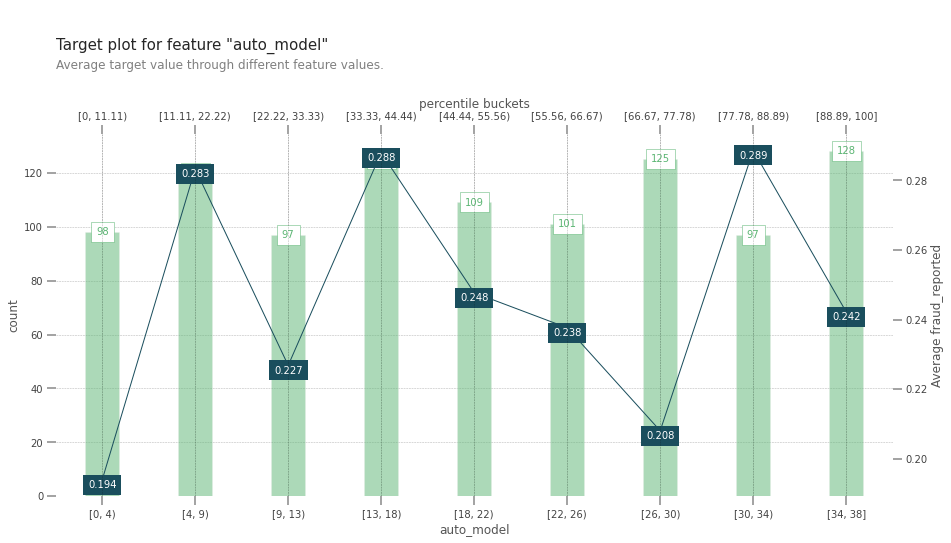

In [ ]:
fig, axes, summary_df = info_plots.target_plot(\
                                               df=data, feature='auto_model', 
                                               feature_name='auto_model', target='fraud_reported', 
                                               show_percentile=True)

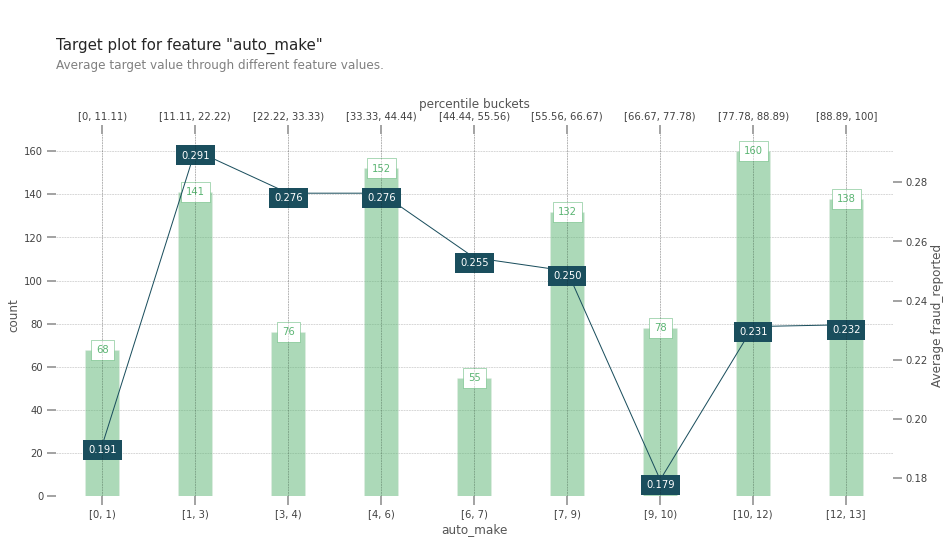

In [ ]:
fig, axes, summary_df = info_plots.target_plot(\
                                               df=data, feature='auto_make', 
                                               feature_name='auto_make', target='fraud_reported', 
                                               show_percentile=True)

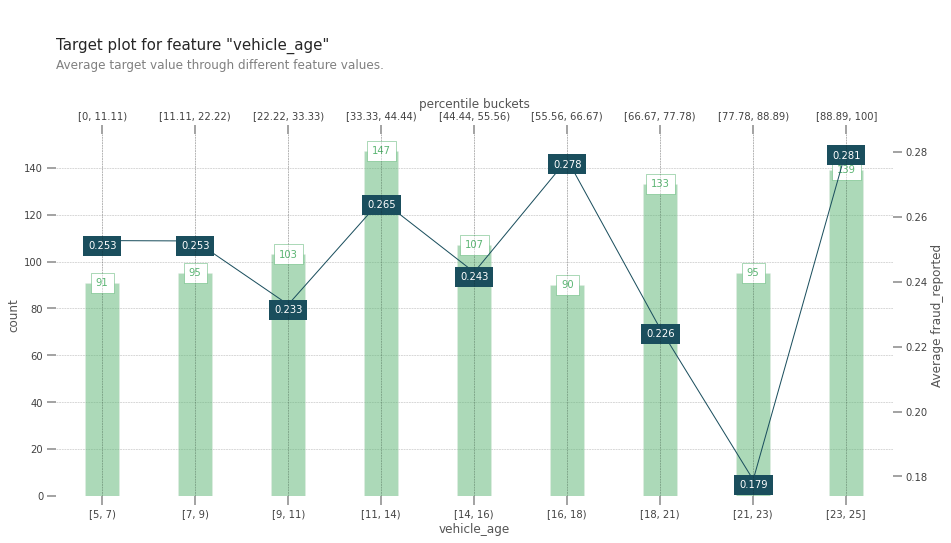

In [ ]:
fig, axes, summary_df = info_plots.target_plot(\
                                               df=data, feature='vehicle_age', 
                                               feature_name='vehicle_age', target='fraud_reported', 
                                               show_percentile=True)

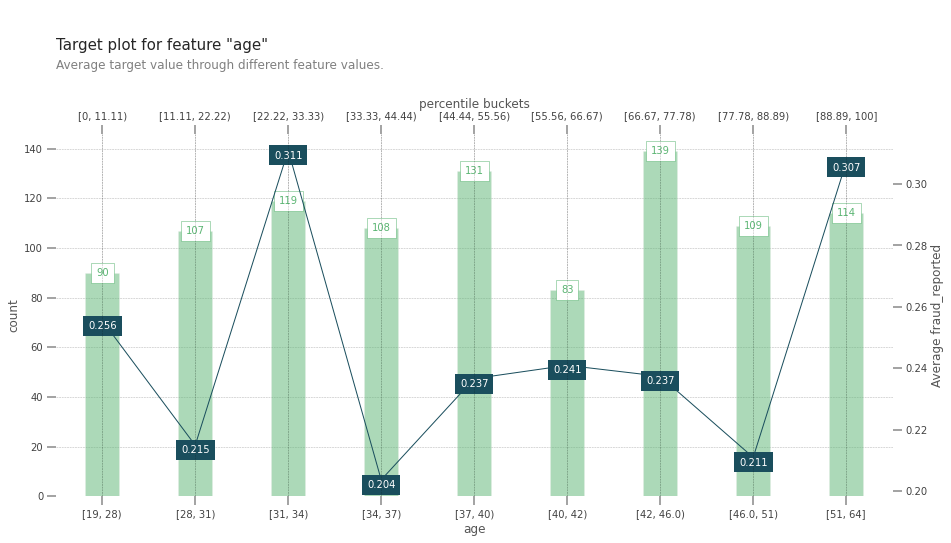

In [ ]:
fig, axes, summary_df = info_plots.target_plot(\
                                               df=data, feature='age', 
                                               feature_name='age', target='fraud_reported', 
                                               show_percentile=True)

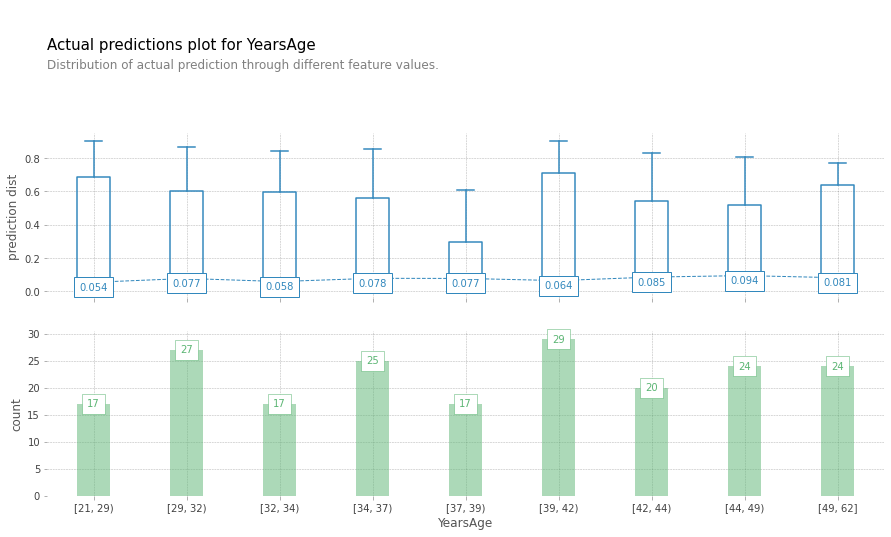

In [ ]:
fig, axes, summary_df = info_plots.actual_plot(\
                                               model, X_test, feature='age', 
                                               feature_name='YearsAge',predict_kwds={})

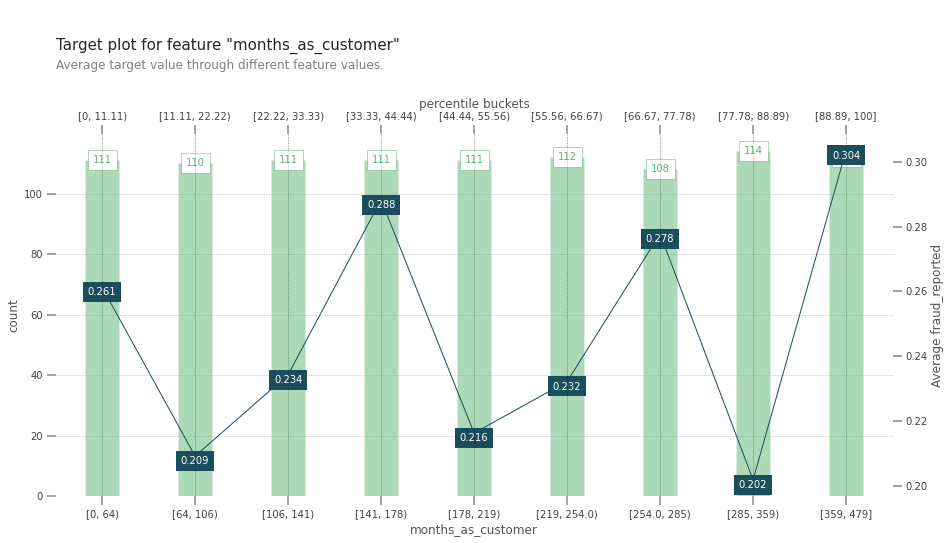

In [ ]:
fig, axes, summary_df = info_plots.target_plot(\
                                               df=data, feature='months_as_customer', 
                                               feature_name='months_as_customer', target='fraud_reported', 
                                               show_percentile=True)

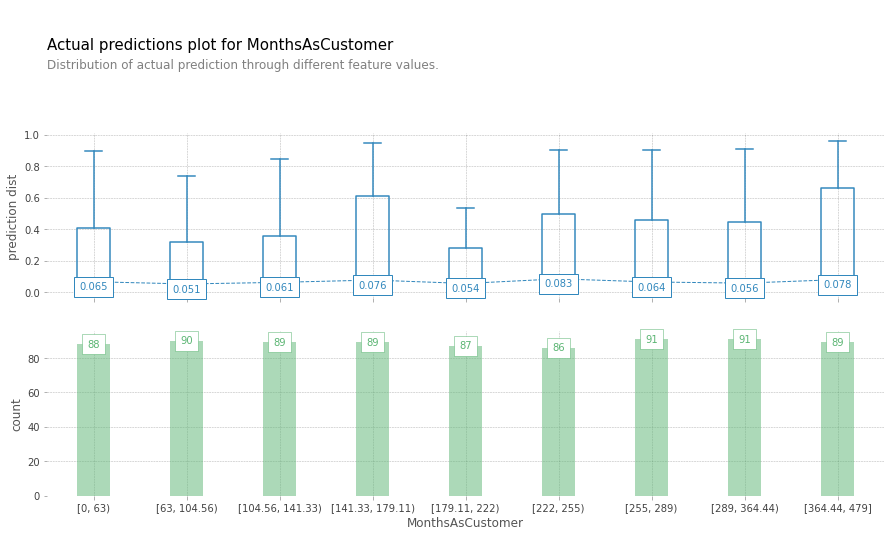

In [110]:
fig, axes, summary_df = info_plots.actual_plot(\
                                               model, X_train, feature='months_as_customer', 
                                               feature_name='MonthsAsCustomer',predict_kwds={})

In [119]:
data.head(1)

,months_as_customer,age,policy_state,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,fraud_reported,csl_per_person,csl_per_accident,vehicle_age,incident_period_of_day
0,328,48,2,1000,1406.91,0,1,4,2,17,0,53300,0,2,3,0,4,4,1,1,2,1,2,2,71610,6510,13020,52080,10,1,1,1,2,16,1


In [112]:
df.insured_education_level.unique()

array(['MD', 'PhD', 'Associate', 'Masters', 'High School', 'College',
       'JD'], dtype=object)

In [120]:
fig, axes, summary_df = info_plots.target_plot(\
                                               df=df, feature=['MD', 'PhD', 'Associate', 
                                                               'Masters', 'High School', 
                                                               'College','JD'], 
                                               feature_name='insured_education_level', 
                                               target='fraud_reported')



ValueError: ignored

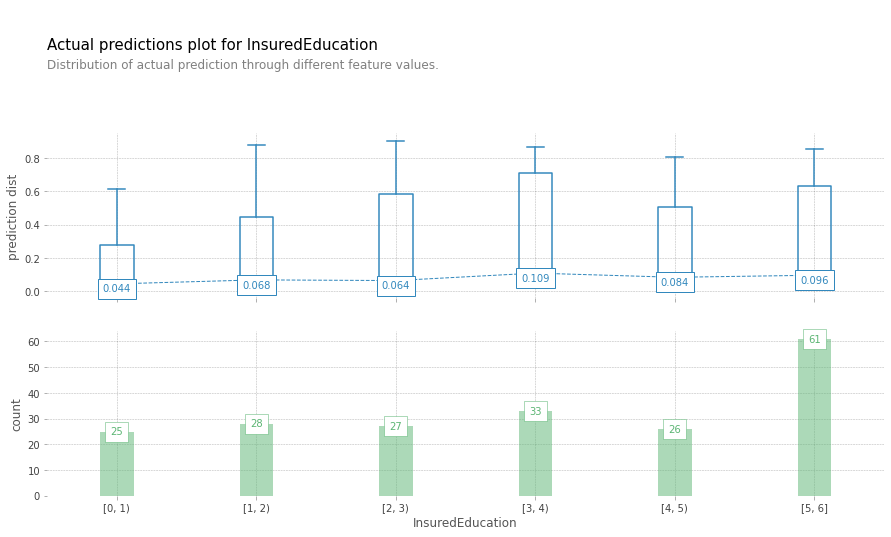

In [ ]:
fig, axes, summary_df = info_plots.actual_plot(\
                                               model, X_test, feature='insured_education_level', 
                                               feature_name='InsuredEducation',predict_kwds={})

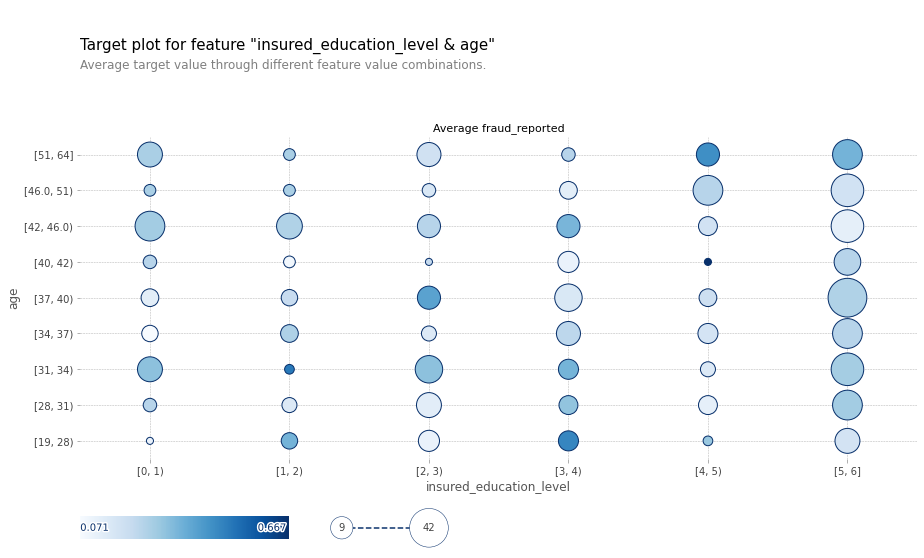

In [ ]:
fig, axes, summary_df = info_plots.target_plot_interact(\
                                                        df=data, 
                                                        features=['insured_education_level', 'age'], 
                                                        feature_names=['insured_education_level', 'age'], 
                                                        target='fraud_reported')

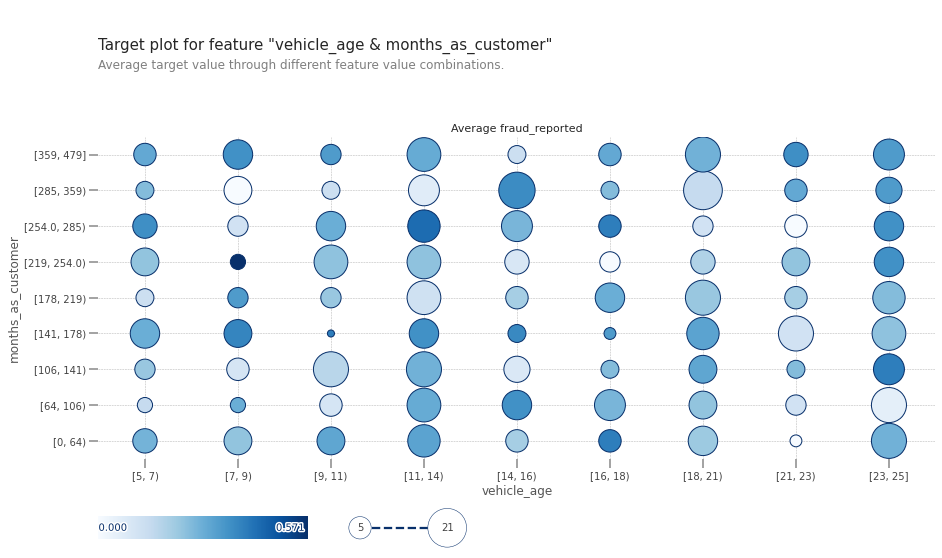

In [ ]:
fig, axes, summary_df = info_plots.target_plot_interact(\
                                                        df=data, 
                                                        features=['vehicle_age', 'months_as_customer'], 
                                                        feature_names=['vehicle_age', 'months_as_customer'], 
                                                        target='fraud_reported')

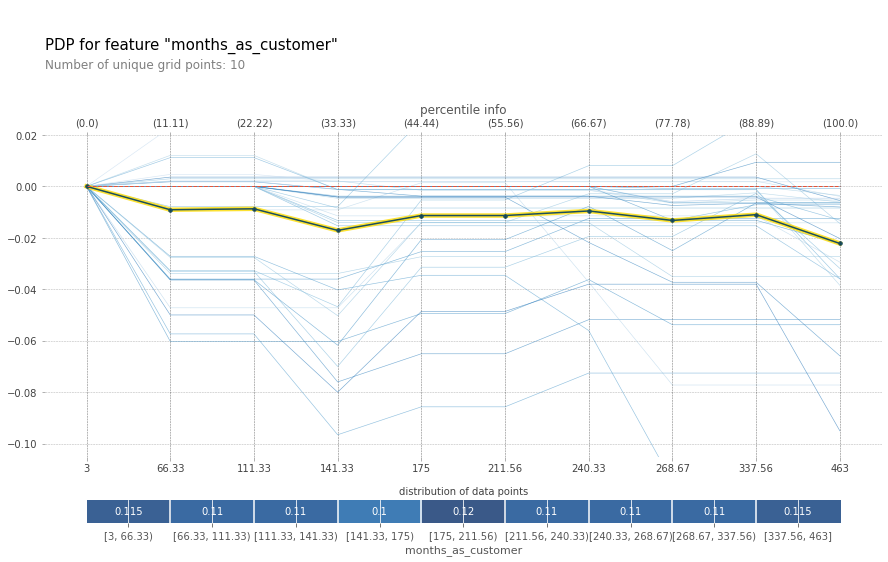

In [ ]:
pdp_limit = pdp.pdp_isolate(\
                            model, dataset=X_test, 
                            model_features=X_test.columns, feature='months_as_customer')
fig, axes = pdp.pdp_plot(\
                         pdp_limit, 'months_as_customer', frac_to_plot=0.2, 
                         plot_lines=True, x_quantile=True, show_percentile=True, 
                         plot_pts_dist=True)
plt.tight_layout()

In [ ]:
df['incident_severity'].unique()

array(['Major Damage', 'Minor Damage', 'Total Loss', 'Trivial Damage'],
      dtype=object)

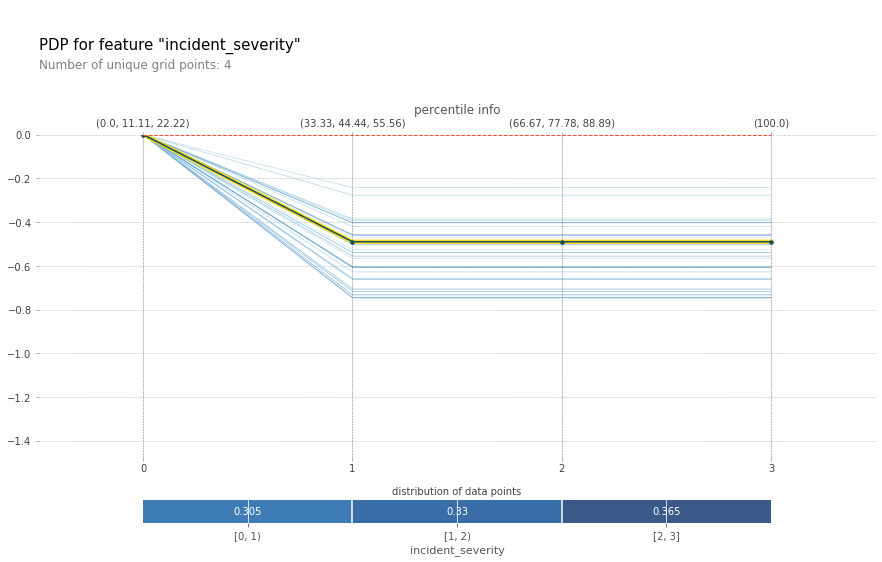

In [ ]:
pdp_limit = pdp.pdp_isolate(\
                            model, dataset=X_test, 
                            model_features=X_test.columns, 
                            feature='incident_severity')
fig, axes = pdp.pdp_plot(\
                         pdp_limit, 'incident_severity', frac_to_plot=0.2, 
                         plot_lines=True, x_quantile=True, show_percentile=True, 
                         plot_pts_dist=True)

In [ ]:
data.head()

,months_as_customer,age,policy_state,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,fraud_reported,csl_per_person,csl_per_accident,vehicle_age,incident_period_of_day
0,328,48,2,1000,1406.91,0,1,4,2,17,0,53300,0,2,3,0,4,4,1,1,2,1,2,2,71610,6510,13020,52080,10,1,1,1,2,16,1
1,228,42,1,2000,1197.22,5000000,1,4,6,15,2,0,0,3,0,1,4,5,5,1,0,0,0,0,5070,780,780,3510,8,12,1,1,2,13,4
2,134,29,2,2000,1413.14,5000000,0,6,11,2,3,35100,0,0,2,1,4,1,1,3,1,2,3,1,34650,7700,3850,23100,4,30,0,0,1,13,4
3,256,41,0,2000,1415.74,6000000,0,6,1,2,4,48900,-62400,2,1,0,4,2,0,1,0,1,2,1,63400,6340,6340,50720,3,34,1,1,2,6,1
4,228,44,0,1000,1583.91,6000000,1,0,11,2,4,66000,-46000,3,0,1,2,1,0,1,1,0,1,1,6500,1300,650,4550,0,31,0,2,0,11,2


In [ ]:
pip install lime

In [ ]:
X_train.columns

Index(['months_as_customer', 'age', 'policy_state', 'policy_deductable', 'policy_annual_premium', 'umbrella_limit', 'insured_sex',
       'insured_education_level', 'insured_occupation', 'insured_hobbies', 'insured_relationship', 'capital-gains', 'capital-loss', 'incident_type',
       'collision_type', 'incident_severity', 'authorities_contacted', 'incident_state', 'incident_city', 'number_of_vehicles_involved',
       'property_damage', 'bodily_injuries', 'witnesses', 'police_report_available', 'total_claim_amount', 'injury_claim', 'property_claim',
       'vehicle_claim', 'auto_make', 'auto_model', 'csl_per_person', 'csl_per_accident', 'vehicle_age', 'incident_period_of_day'],
      dtype='object')

In [ ]:
pip install shap

     |████████████████████████████████| 276kB 4.2MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394116 sha256=739559aa704d79e417b4fbb5936912c5c346b471f6fd7e0e8b1d0e078b6516d2
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


<IPython.core.display.Javascript object>

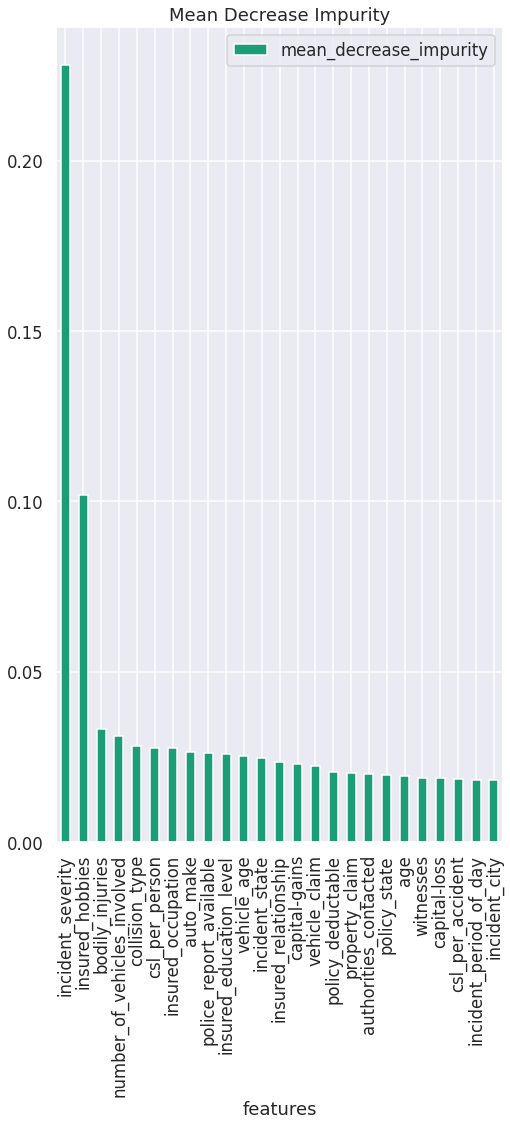

In [ ]:
# get the feature importances from each tree and then visualize the
# distributions as boxplots
all_feat_imp_df = pd.DataFrame(data=[tree.feature_importances_ for tree in clf],
                               columns=X_train.columns)
order_column = all_feat_imp_df.mean(axis=0).sort_values(ascending=False).index.tolist()
 
 
all_feat_imp_df[order_column[:25]].iplot(kind='box', xTitle = 'Features', yTitle='Mean Decease Impurity')

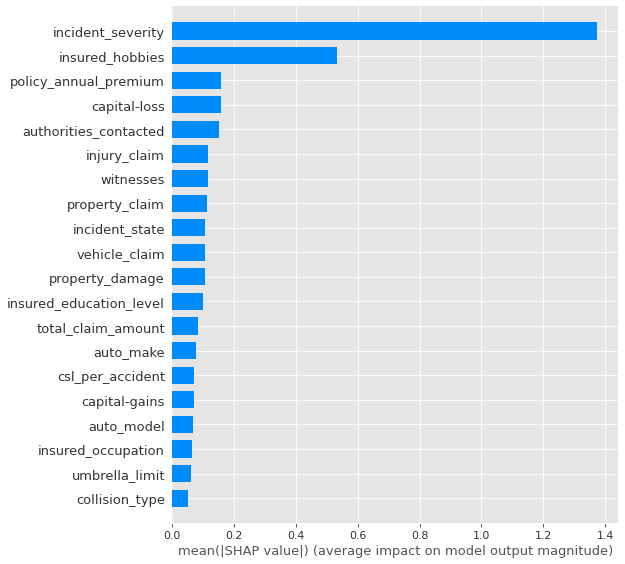

In [ ]:
import shap
shap_values = shap.TreeExplainer(model).shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [ ]:
X_test.iloc[1,:]

months_as_customer                  96.00
age                                 30.00
policy_state                         2.00
policy_deductable                  500.00
policy_annual_premium             1399.27
umbrella_limit                 6000000.00
insured_sex                          1.00
insured_education_level              1.00
insured_occupation                   9.00
insured_hobbies                     10.00
insured_relationship                 5.00
capital-gains                    38900.00
capital-loss                    -48700.00
incident_type                        2.00
collision_type                       3.00
incident_severity                    2.00
authorities_contacted                1.00
incident_state                       0.00
incident_city                        0.00
number_of_vehicles_involved          1.00
property_damage                      0.00
bodily_injuries                      0.00
witnesses                            0.00
police_report_available           

In [ ]:
import shap

# Initialize your Jupyter notebook with initjs(), otherwise you will get an error message.
shap.initjs()
# j will be the record we explain
j = 1

explainerXGB = shap.TreeExplainer(model)
shap_values_XGB_test = explainerXGB.shap_values(X_test)
shap.force_plot(explainerXGB.expected_value, shap_values_XGB_test[j], X_test.iloc[[j]])


This plot shows a base value that is used to indicate the direction of the prediction. Seeing as most of the targets are 0, it isn’t strange to see that the base value is negative.

The red bar shows how much the probability that the target is 1. Higher education typically leads to
making more.
The blue bars show that these variables decrease the probability, with Agehaving the biggest effect. This makes sense as younger people typically make
less.

We predicted -3.26, whereas the base_value is -1.37. Feature values causing increased predictions are in pink, and their visual size shows the magnitude of the feature's effect. Feature values decreasing the prediction are in blue. The biggest impact comes from authorities contacted being 4. Though incident severity value has a meaningful effect decreasing the prediction.

In [ ]:
# visualize the training set predictions
# load JS visualization code to notebook
shap.initjs()
shap.force_plot(explainerXGB.expected_value, shap_values, X_test)

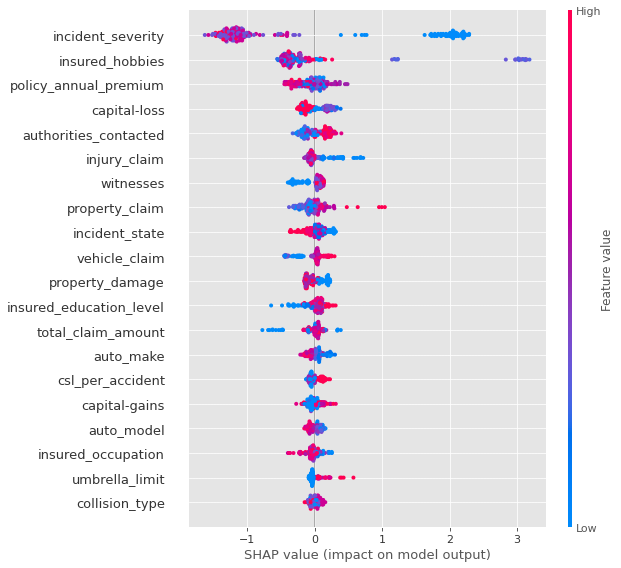

In [ ]:
shap.summary_plot(shap_values, X_test)

In [ ]:
clf.predict_proba(X_test)[-5:]

array([[0.95793366, 0.04206637],
       [0.9233208 , 0.07667924],
       [0.93861187, 0.06138813],
       [0.89517087, 0.10482914],
       [0.27756596, 0.72243404]], dtype=float32)

In [ ]:
from pdpbox import pdp_plot_utils

# Override to fix matplotlib issue
def _pdp_contour_plot_override(X, Y, pdp_mx, inter_ax, cmap, norm, inter_fill_alpha, fontsize, plot_params):
    contour_color = plot_params.get('contour_color', 'white')
    level = np.min([X.shape[0], X.shape[1]])
    c1 = inter_ax.contourf(X, Y, pdp_mx, N=level, origin='lower', cmap=cmap, norm=norm, alpha=inter_fill_alpha)
    c2 = inter_ax.contour(c1, levels=c1.levels, colors=contour_color, origin='lower')
    inter_ax.clabel(c2, fontsize=fontsize, inline=1)
    inter_ax.set_aspect('auto')
    return c1

pdp_plot_utils._pdp_contour_plot = _pdp_contour_plot_override

pdp_inter = pdp.pdp_interact(
    model=model, dataset=X_train, model_features=X_train.columns, features=['mean concavity', 'mean radius']
)

fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out=pdp_inter, feature_names=['mean concavity', 'mean radius'], plot_type='contour',
    x_quantile=True, plot_pdp=True
)

ValueError: ignored